<a href="https://colab.research.google.com/github/FCHEHIDI/CodeCraftHub/blob/main/Text_Analysis_with_a_Convolution_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text Analysis with a Convolution Layer**

Imports

In [1]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

Load the dataset

In [2]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2025-05-07 02:43:58--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.184.207, 142.251.189.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.184.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2025-05-07 02:43:58 (206 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [5]:
#Load the JSON file

with open("./sarcasm.json", 'r') as f:
  datastore = json.load(f)

#Initialize the lists
sentences = []
labels = []
#Collect the sentences and labels into the lists
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

Parameters

In [6]:
#Number of examples to use for training
TRAINING_SIZE = 20000

#Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

#Maximum lenght of the padded sequences
MAX_LENGHT = 32

#Type of padding
PADDING_TYPE = 'pre'

#Specify how to truncate the sequences
TRUNC_TYPE = 'post'

Split the dataset

In [7]:
#Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

#Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

Data preprocessing

In [8]:
#Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

#Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

#Preprocess the train and the test data
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

In [14]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.dat.Dataset'''

  #Apply the vectorization layer to the reviews
  dataset_sequences = dataset.map(lambda review, label : (vectorize_layer(review), label))

  #Put all ellements in a single ragged batch
  dataset_sequences = dataset_sequences.ragged_batch(batch_size= dataset_sequences.cardinality())

  #Output a tensor from the single ragged batch. Extract the sequences and labels
  sequences, labels = dataset_sequences.get_single_element()

  #Padd the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), maxlen= MAX_LENGHT, truncating = TRUNC_TYPE, padding = PADDING_TYPE)

  #Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  #Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [15]:
#Preprocess the train and the test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

In [16]:
#View two training sequences and its labels

for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [17]:
#Optimize and batch the dataset fro training

SHUFFLE_BUFFER_SIZE = 10000
PREFECTH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset_final = train_dataset_vectorized.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFECTH_BUFFER_SIZE)
test_dataset_final = test_dataset_vectorized.cache().prefetch(PREFECTH_BUFFER_SIZE).batch(BATCH_SIZE)

Plot Utility

In [18]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12,6))
  ax[0].plot(epochs, acc, 'r', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'r', label='Training loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  plt.show()


Build and Compile the Model

In [19]:
#Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

#Model Definition with Conv1D

model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGHT,)),
    tf.keras.layers.Embedding(input_dim= VOCAB_SIZE, output_dim= EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Set the training parameters
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Print the model summary
model_conv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [20]:
history = model_conv.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5492 - loss: 0.6902 - val_accuracy: 0.5633 - val_loss: 0.6855
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6933 - loss: 0.5498 - val_accuracy: 0.8463 - val_loss: 0.3417
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9154 - loss: 0.2197 - val_accuracy: 0.8550 - val_loss: 0.3578
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9593 - loss: 0.1171 - val_accuracy: 0.8520 - val_loss: 0.4286
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9815 - loss: 0.0600 - val_accuracy: 0.8457 - val_loss: 0.5244
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9938 - loss: 0.0268 - val_accuracy: 0.8411 - val_loss: 0.6345
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9971 - loss: 0.0142 - val_accuracy: 0.8436 - val_loss: 0.7028
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9992 - loss: 0.0059 - val_accuracy: 0

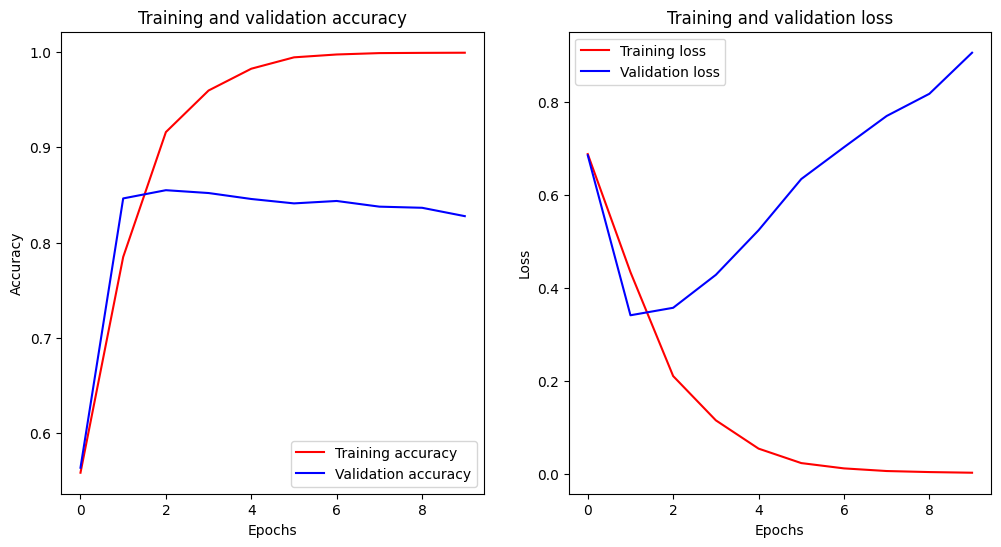

In [21]:
plot_loss_acc(history)